In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

In [2]:

df = pd.read_csv('NASDAQ1.csv')
data = df.sort_index(ascending=True, axis=0)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2/5/1971,100.000000,100.000000,100.000000,100.000000,100.000000,0
1,2/8/1971,100.839996,100.839996,100.839996,100.839996,100.839996,0
2,2/9/1971,100.760002,100.760002,100.760002,100.760002,100.760002,0
3,2/10/1971,100.690002,100.690002,100.690002,100.690002,100.690002,0
4,2/11/1971,101.449997,101.449997,101.449997,101.449997,101.449997,0
...,...,...,...,...,...,...,...
12593,1/11/2021,13048.780270,13138.269530,12999.509770,13036.429690,13036.429690,6876420000
12594,1/12/2021,13062.059570,13105.040040,12963.919920,13072.429690,13072.429690,7181380000
12595,1/13/2021,13088.009770,13171.150390,13051.059570,13128.950200,13128.950200,7072920000
12596,1/14/2021,13174.750000,13220.160160,13098.410160,13112.639650,13112.639650,6671090000


In [3]:
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])


In [4]:
for i in range(0, len(data)):
    new_data['Date'][i] = data["Date"][i]
    new_data['Close'][i] = data["Close"][i]

In [5]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [6]:
#creating train and test sets
dataset = new_data.values
train = dataset[0:10000,:]
valid = dataset[10000:,:]


In [7]:

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


In [8]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [9]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [10]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

9940/9940 - 191s - loss: 5.0420e-05


In [11]:
model_loss, model_accuracy = model.evaluate(x_train, y_train, verbose=2)

311/311 - 3s - loss: 1.3290e-05


TypeError: cannot unpack non-iterable float object

In [12]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [13]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [14]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
closing_price

array([[ 2391.5137],
       [ 2387.6038],
       [ 2379.3215],
       ...,
       [12915.749 ],
       [12942.482 ],
       [12947.946 ]], dtype=float32)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [16]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

104.98700219827049

<ipython-input-17-fe20a2479420>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


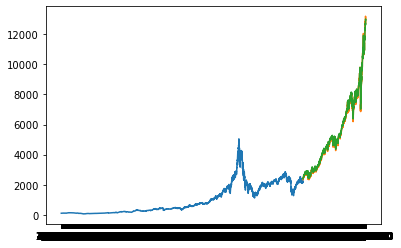

In [17]:
import matplotlib.pyplot as plt
#for plotting
train = new_data[:10000]
valid = new_data[10000:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [20]:

from keras.models import load_model

model.save('LSTM_Stock_Predictions.h5')  # creates a HDF5 file 'my_model.h5'

In [18]:
# Get the quote
new_df = data.filter(['Close'])

last_60_days = new_df[-60:].values

last_60_days_scaled = scaler.transform(last_60_days)

X_test = []

X_test.append(last_60_days_scaled)

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[12872.154]]
